In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

# Rotated MNIST dataset
Jan 22, 2021

Equivalent to MonoMNIST, but with rotation angle as the "domain" / style.


In [3]:
import pandas as pd

import numpy as np
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Any, List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [5]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
# print(sys.path)

Project root:  /data/hayley-old/Tenanbaum2000
Src folder:  /data/hayley-old/Tenanbaum2000/src
This nb path:  /data/hayley-old/Tenanbaum2000/nbs

/data/hayley-old/Tenanbaum2000 added to the path.


In [6]:
from src.data.datamodules.maptiles_datamodule import MaptilesDataModule

from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler, Monochromizer
from src.data.transforms.functional import unnormalize, to_monochrome

from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info
from collections import OrderedDict, defaultdict
from PIL import Image

In [7]:
from PIL.Image import Image

In [8]:
import torchvision.transforms.functional as TF


## Test rotated mnist dataset class

In [9]:
from src.data.datasets.rotated_mnist import RotatedMNIST

In [12]:
data_root = '/data/hayley-old/Tenanbaum2000/data'
ds_30 = RotatedMNIST(data_root, 30)
ds_45 = RotatedMNIST(data_root, 45)
ds_0 = RotatedMNIST(data_root, 0)
ds_n30 = RotatedMNIST(data_root, -30)
ds_n45 = RotatedMNIST(data_root, -45)

angle:  0


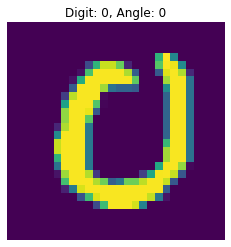

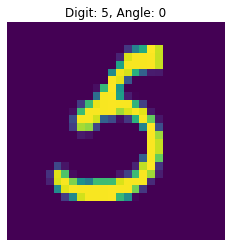

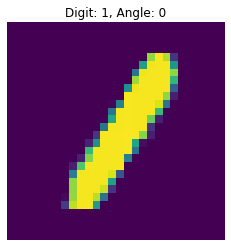

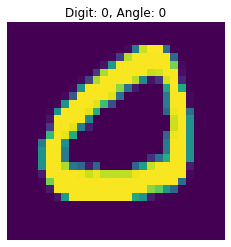

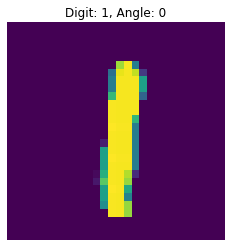

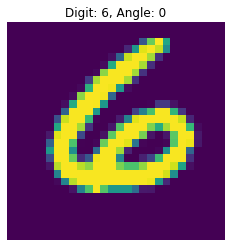

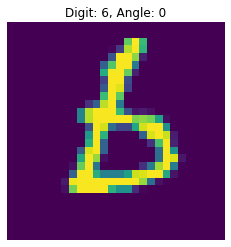

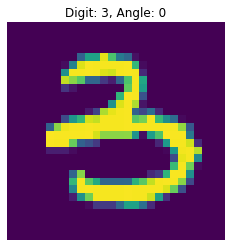

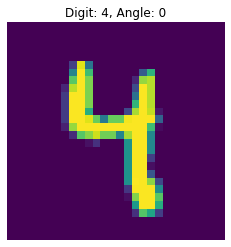

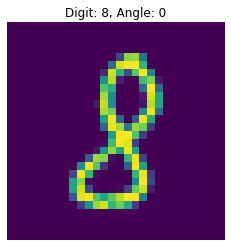

In [13]:
ds = ds_0
print("angle: ", ds_0.angle)

for i in range(10):
    ind = np.random.choice(len(ds))
    sample = ds[ind]
    x, y, d = ds.unpack(sample)
    show_timg(x)
    plt.title(f"Digit: {y}, Angle: {d}")


In [14]:
angles = [45, 30, 0, -30, -45]
dsets = {}
for angle in angles:
    dsets[angle] = RotatedMNIST(data_root, angle)
    

angle:  45 45
angle:  30 30
angle:  0 0
angle:  -30 -30
angle:  -45 -45


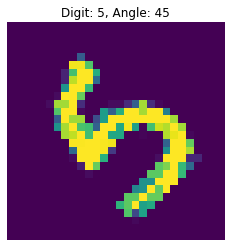

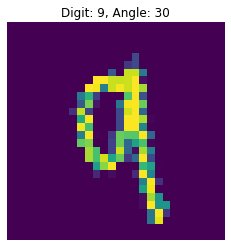

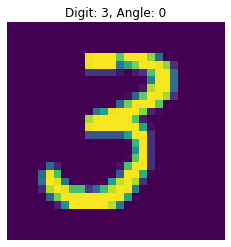

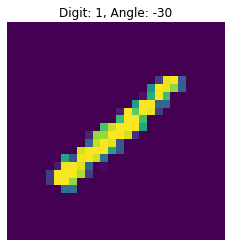

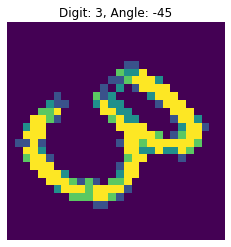

In [15]:
for angle, dset in dsets.items():
    print("angle: ", angle, dset.angle)
    ind = np.random.choice(len(dset))
    sample = dset[ind]
    x, y, d = dset.unpack(sample)
    show_timg(x)
    plt.title(f"Digit: {y}, Angle: {d}")
    

## Multisource Rotated MNIST dataset
A dataset created by concatenating multiple RotatedMNIST datasets



In [9]:
from src.data.datasets.multisource_rotated_mnist import MultiRotatedMNIST

In [10]:
data_root = '/data/hayley-old/Tenanbaum2000/data'
angles = [0, -90]
ds = MultiRotatedMNIST(data_root=data_root, angles=angles)

angle:  -90  , type:  <class 'int'>
angle:  0  , type:  <class 'int'>


In [12]:
print(ds[0]['angle'], ds[70000]['angle'])
print(len(ds))


Lambda()
Lambda()
0 1
120000


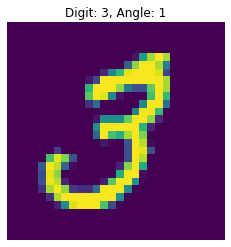

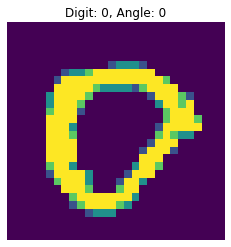

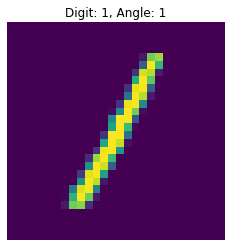

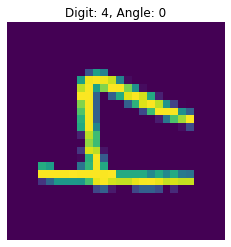

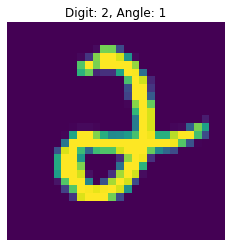

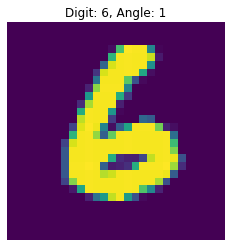

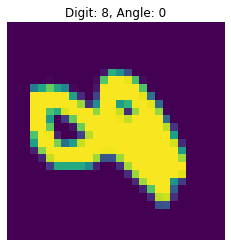

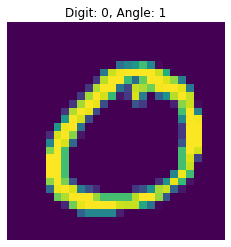

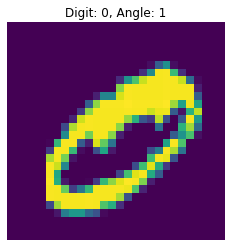

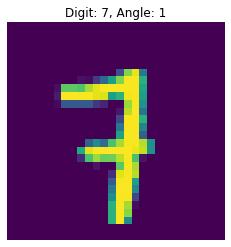

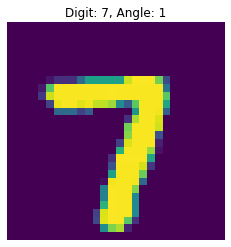

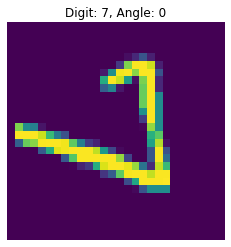

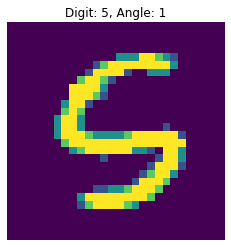

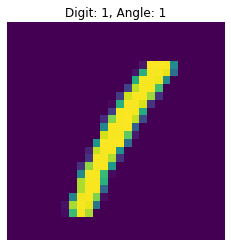

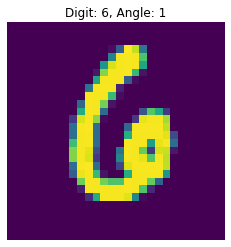

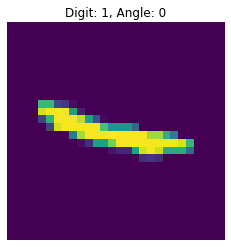

In [13]:
n_samples = 16
for i in range(n_samples):
    ind = np.random.choice(len(ds))
    sample = ds[ind]
    x, y, d = ds.unpack(sample)
    show_timg(x)
    plt.title(f"Digit: {y}, Angle: {d}")
    

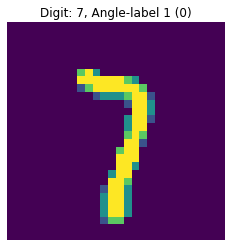

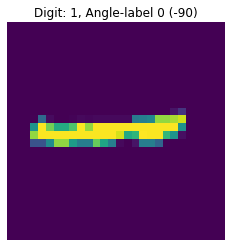

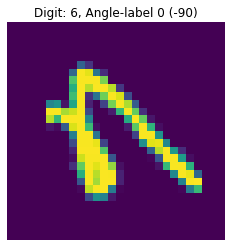

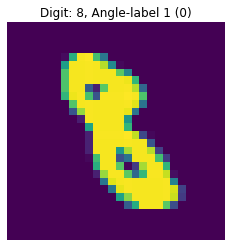

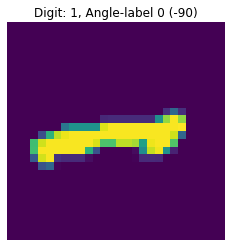

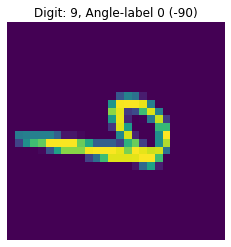

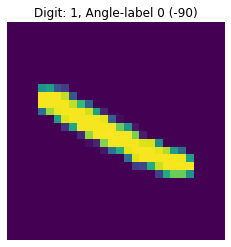

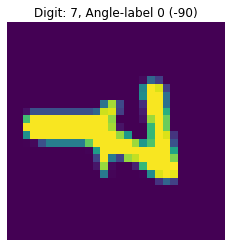

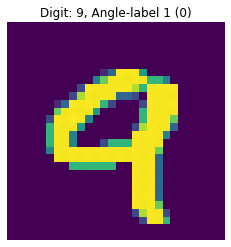

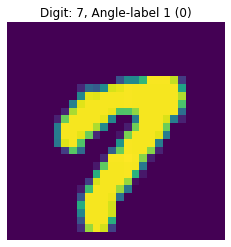

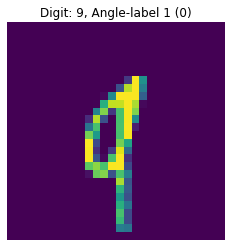

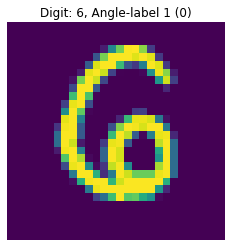

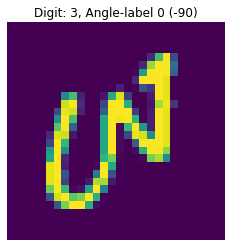

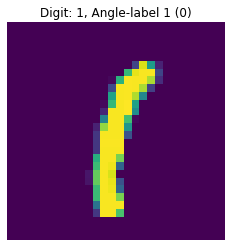

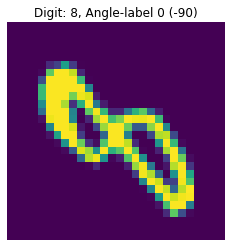

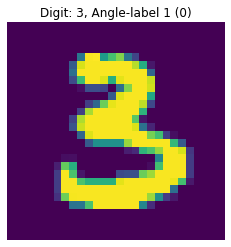

In [14]:
bs = 16
dl = DataLoader(ds, batch_size=bs, shuffle=True,
               num_workers=16, pin_memory=True)
for batch in dl:
    x,y,d = ds.unpack(batch)
    for i in range(len(x)):
        show_timg(x[i])
        plt.title(
            f"Digit: {y[i]}, Angle-label {d[i]} ({ds.idx2angle[int(d[i])]})"
        )
        plt.show()
    break

## Multisource Rotated MNIST Datamodule

### Final Workflow
- Specify dataset settings 
  - colors, batch_size, shape of each datapoint (`in_shape`)
- Initialize a multisource MonoMNIST dataset
- Initialize a multisource MonoMNIST datamodule using the dataset

In [15]:
from src.data.datamodules.multisource_rotated_mnist_datamodule import MultiRotatedMNISTDataModule

In [16]:
# Dataset settings
data_dir = Path("/data/hayley-old/Tenanbaum2000/data/")
angles = [0, -90]
seed = 123
in_shape = (1, 32, 32)
batch_size = 32

In [20]:
# Create a concat dataset from multiple mono-mnist datasets
ds = MultiRotatedMNIST(
    data_root=data_dir,
    angles=angles,
)
print("===Num. of observations===")
print([len(d) for d in ds.dsets])

angle:  -90  , type:  <class 'int'>
angle:  0  , type:  <class 'int'>
===Num. of observations===
[60000, 60000]


In [18]:
# Create a multisource rotated-mnist datamodule
dm = MultiRotatedMNISTDataModule(
    data_root=data_dir,
    angles=angles,
    in_shape=in_shape,
    batch_size=batch_size,
    shuffle=True,
    split_seed=seed,
)
dm.setup('fit')

angle:  -90  , type:  <class 'int'>
angle:  0  , type:  <class 'int'>


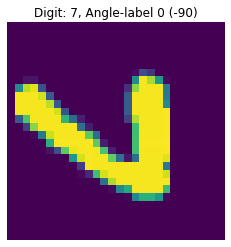

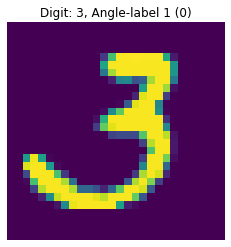

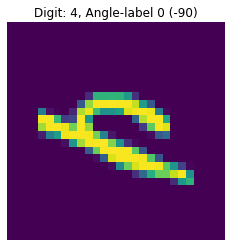

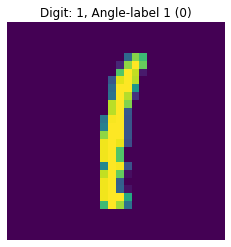

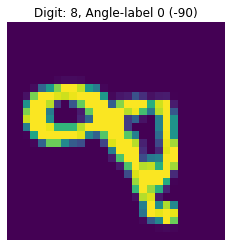

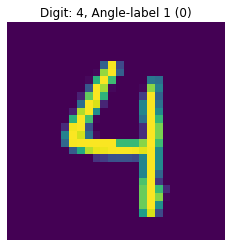

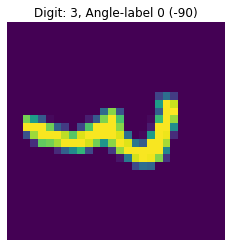

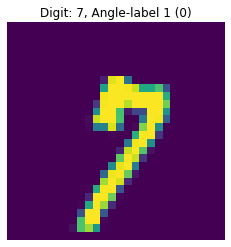

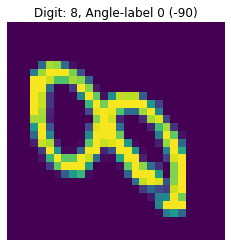

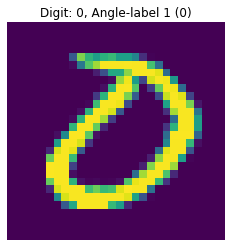

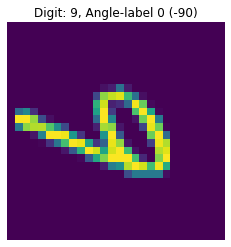

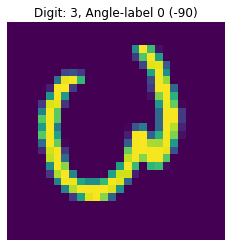

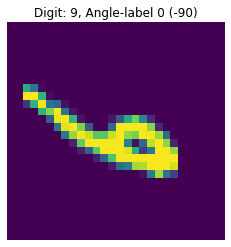

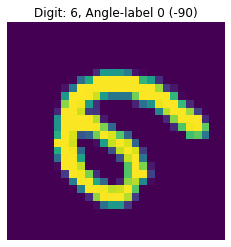

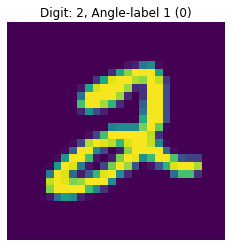

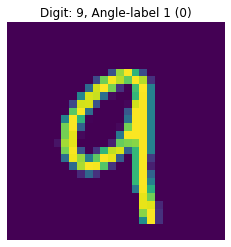

In [21]:
bs = 16
dl = DataLoader(ds, batch_size=bs, shuffle=True,
               num_workers=1, pin_memory=True)
for batch in dl:
    x,y,d = ds.unpack(batch)
    for i in range(len(x)):
        show_timg(x[i])
        plt.title(
            f"Digit: {y[i]}, Angle-label {d[i]} ({ds.idx2angle[int(d[i])]})"
        )
        plt.show()
    break

In [22]:
dm.name
dl = dm.train_dataloader()

tensor([7, 2, 9, 8, 8, 3, 9, 8, 3, 6, 0, 3, 0, 2, 3, 0, 1, 2, 4, 0, 3, 4, 1, 0,
        5, 8, 0, 6, 4, 1, 0, 6])
tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1])
===


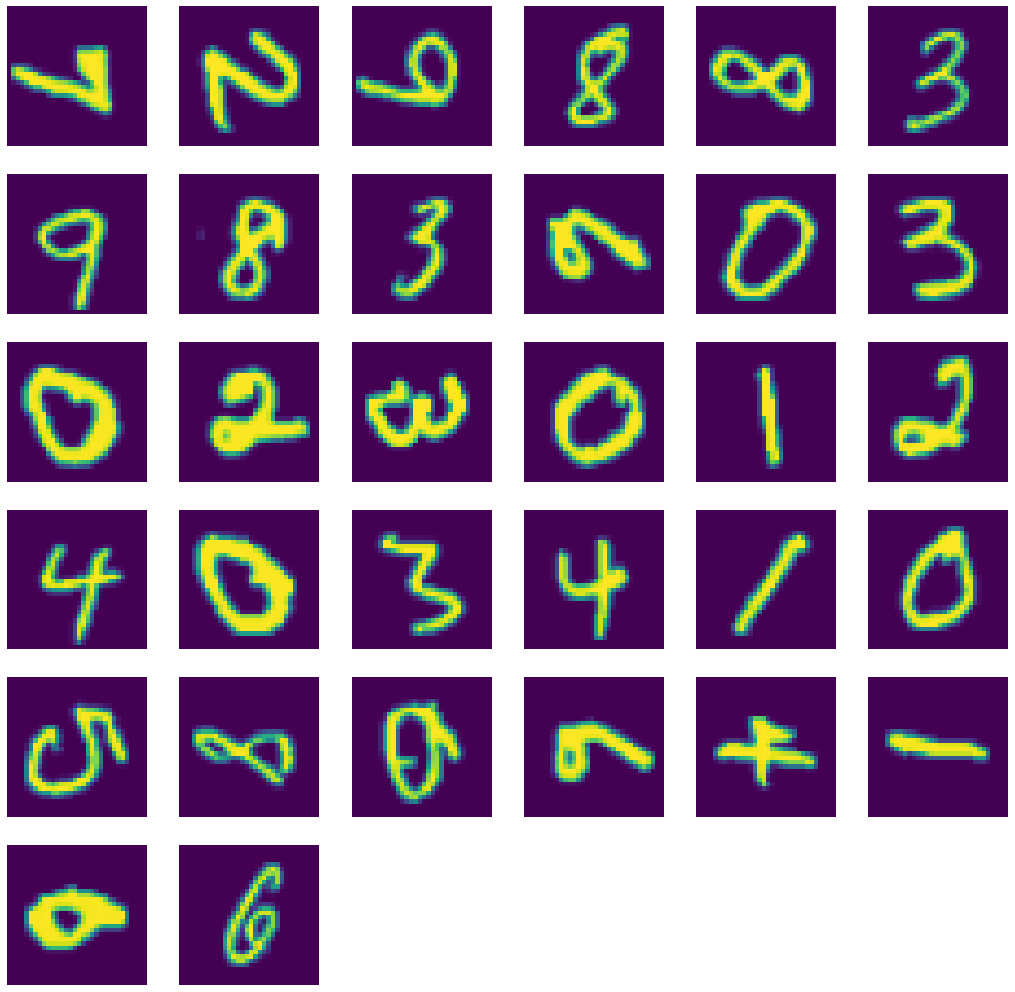

In [23]:
# Show a batch
batch = next(iter(dl))
x, label_c, label_s = dm.unpack(batch)
show_timgs(x)
print(label_c)
print(label_s)
print("===")